In [ ]:
!pip install netCDF4
!pip install datasets
!pip install germansentiment

In [ ]:
import pandas as pd
import numpy as np
import datasets
import transformers

feedback = pd.read_csv("External_data.csv")

feedback.head(5)

,label,text
0,1,theoretisch kannste dir überall im Kölner Stad...
1,0,Bahn verspätet sich..gleich kommt noch jemand ...
2,0,"""Mama, der bei der Bahn war so inkompetent, ha..."
3,0,Re: Störticker Bayern [S-Bahn M] Stammstrecke:...
4,0,Lokführerstreik geht weiter: Wieder viele Zuga...


<ipython-input-3-b49a66aa95db>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  feedback['text'] = feedback['text'].str.replace(url_pattern, '', flags=re.MULTILINE)
<ipython-input-3-b49a66aa95db>:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  feedback['text'] = feedback['text'].str.replace(char, '')
<ipython-input-3-b49a66aa95db>:40: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  feedback['text'] = feedback['text'].str.replace(char, '')


  label                                               text
0     1  theoretisch kannste dir überall im kölner stad...
1     0  bahn verspätet sichgleich kommt noch jemand un...
2     0  mama der bei der bahn war so inkompetent hab b...


0    5228
1    1216
Name: label, dtype: int64

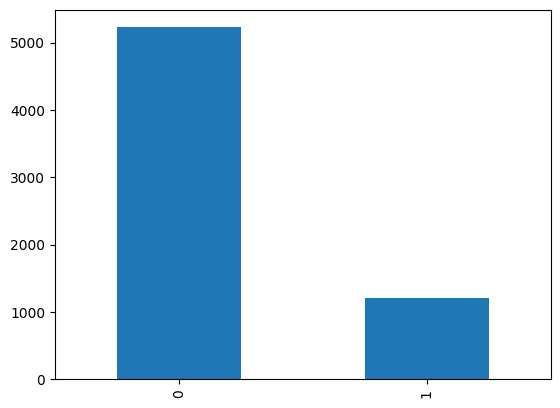

In [ ]:
from nltk.tokenize import RegexpTokenizer
import re
def make_lower_case(text):
    return text.lower()

feedback = feedback.astype(str)
feedback['text'] = feedback.text.apply(func = make_lower_case)
feedback.head(5)

feedback = feedback.replace('nan', np.nan) #convert the strings to NaN values
feedback=feedback.dropna(subset=['text']) #drop the rows with null values

feedback['text'] = feedback['text'].str.split().str.join(" ")
feedback.head(5)

import re

# Define a regular expression pattern to match URLs
url_pattern = r'https?://\S+|www\.\S+'

# Replace URLs with an empty string in the 'text' column
feedback['text'] = feedback['text'].str.replace(url_pattern, '', flags=re.MULTILINE)

# Remove any extra whitespace
feedback['text'] = feedback['text'].str.strip()

spec_chars = ["!",'"',"#","%","&","'","(",")",
             "*","+",",","-",".",":",";","<",
             "=",">","?","@","[","]","^","_",
             "`","{","|","}","~","–"]
for char in spec_chars:
    feedback['text'] = feedback['text'].str.replace(char, '')

# Dropping those having installation ids
feedback = feedback[feedback["text"].str.contains("installation id") == False]
feedback.head(3)

spec_chars = ["\\"]
for char in spec_chars:
    feedback['text'] = feedback['text'].str.replace(char, '')
print(feedback.head(3))

from netCDF4 import Dataset
feedback.head(3)

feedback['label'].value_counts().plot(kind='bar')
feedback['label'].value_counts()

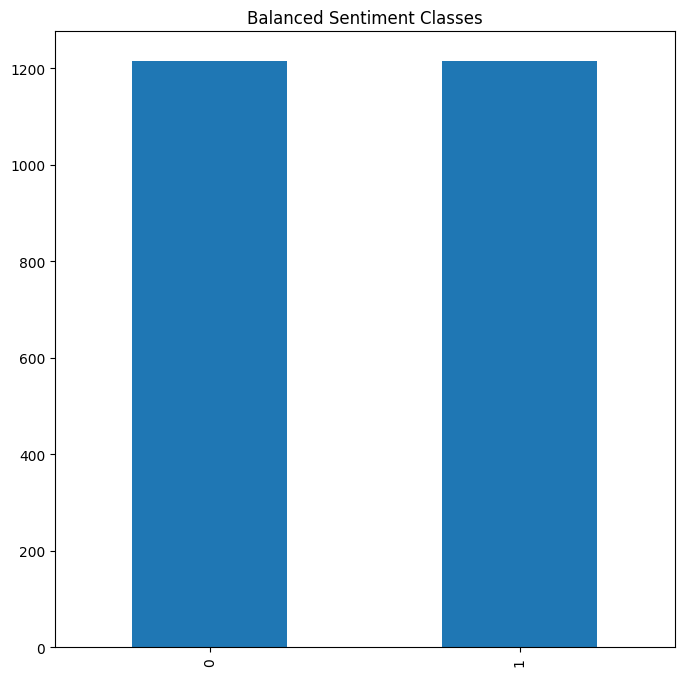

In [ ]:
pos_df = feedback.loc[feedback['label'] == '1']
neg_df = feedback.loc[feedback['label'] == '0'].sample(n=1216,random_state=42)

import seaborn as sns
import matplotlib.pyplot as plt

# Concatenate both dataframes again
normalized_df = pd.concat([neg_df, pos_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
normalized_df['label'].value_counts().plot(kind='bar')
plt.title('Balanced Sentiment Classes')
plt.show()

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1824
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 608
    })
})

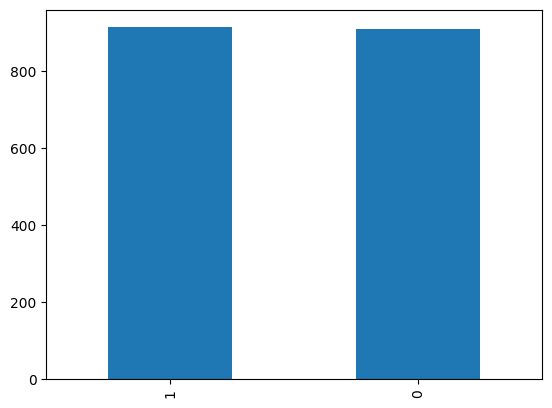

In [ ]:
train = normalized_df.sample(frac = 0.75, random_state=5)
test = normalized_df.drop(train.index)

train.to_csv("train.csv", index = False)
test.to_csv("test.csv", index = False)

train['label'].value_counts().plot(kind='bar')

dataset = datasets.load_dataset('csv', data_files = {'train':'train.csv', 'test':'test.csv'})

dataset

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from transformers import DistilBertTokenizerFast, BertTokenizer, BertForMaskedLM

import datasets
import transformers
from netCDF4 import Dataset
from germansentiment import SentimentModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

def preprocess_function(train):
   return tokenizer(train["text"], truncation=True, padding='max_length')

type(dataset)

type(dataset["train"][0]["text"])

#tokenized = dataset.map(preprocess_function)
tokenized = dataset.map(
    preprocess_function
)

print(len(tokenized['train']))
print(len(tokenized['test']))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1824 [00:00<?, ? examples/s]

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

1824
608


In [ ]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

checkpoint = "bert-base-german-cased"

# Load model directly
model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=2)

#model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-3c89317b6dd6>:16: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` w

In [ ]:
# Upgrade and install necessary dependencies
!pip install transformers[torch]
!pip install accelerate -U

# Restart runtime after executing the above commands: IMPORTANT!

# Import libraries
import accelerate
from transformers import TrainingArguments, Trainer

# Your code for TrainingArguments and Trainer


training_args = TrainingArguments(
    output_dir="./results3",
    save_strategy='no',
    learning_rate=5e-5, #learning rate
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    gradient_accumulation_steps=16  # Enable gradient accumulation
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized['train'],
    eval_dataset=tokenized['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.662880,0.615132
1,No log,0.631638,0.682566
2,No log,0.616069,0.694079


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.662880,0.615132
1,No log,0.631638,0.682566
2,No log,0.616069,0.694079
3,No log,0.606727,0.702303


TrainOutput(global_step=28, training_loss=0.6371703829084124, metrics={'train_runtime': 12685.9321, 'train_samples_per_second': 0.575, 'train_steps_per_second': 0.002, 'total_flos': 1885980044820480.0, 'train_loss': 0.6371703829084124, 'epoch': 3.93})

In [ ]:
model.save_pretrained("German_sentiment_1e5") #With the test set prepared,
#we can save our fine-tuned model and apply it to generate predictions on the test set.
tokenizer.save_pretrained("German_sentiment_1e5")
!zip -r German_sentiment_1e5.zip German_sentiment_1e5/

  adding: German_sentiment_1e5/ (stored 0%)
  adding: German_sentiment_1e5/vocab.txt (deflated 57%)
  adding: German_sentiment_1e5/model.safetensors (deflated 7%)
  adding: German_sentiment_1e5/config.json (deflated 49%)
  adding: German_sentiment_1e5/tokenizer.json (deflated 71%)
  adding: German_sentiment_1e5/tokenizer_config.json (deflated 76%)
  adding: German_sentiment_1e5/special_tokens_map.json (deflated 42%)


In [ ]:
import shutil

# Create a zip file containing the model and tokenizer
shutil.make_archive("German_sentiment_1e5", "zip", "German_sentiment_1e5")

# Move the zip file to the /content directory for easier download
shutil.move("German_sentiment_1e5.zip", "/content/German_sentiment_1e5.zip")

'/content/German_sentiment_1e5.zip'

In [ ]:
from google.colab import files

files.download("/content/German_sentiment_1e5.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy: 0.6990131578947368


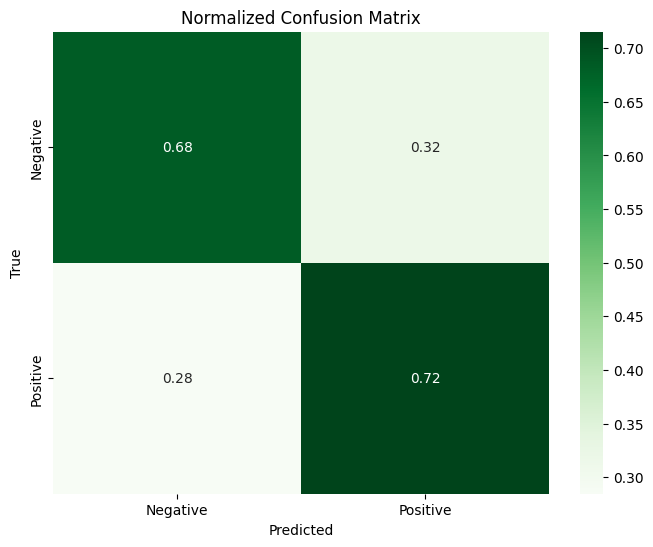

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# Load the trained model and tokenizer
model_name = "German_sentiment_1e5"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Load your test data from External_data.csv
test_data = pd.read_csv("test.csv")

# Preprocess labels to ensure they are integers (0 or 1)
test_data["label"] = test_data["label"].astype(int)

# Prepare the test data by tokenizing it
test_input = tokenizer(
    test_data["text"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

# Create a PyTorch dataset
from torch.utils.data import Dataset, DataLoader, TensorDataset
test_dataset = TensorDataset(
    test_input.input_ids,
    test_input.attention_mask,
    torch.tensor(test_data["label"].tolist())
)

# Create a DataLoader for batch processing
batch_size = 8
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Create a classification pipeline
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Evaluate model accuracy
predictions = []
true_labels = []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    outputs = classifier([tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids])
    # Extract label values from the prediction output
    label_values = [pred['label'] for pred in outputs]
    # Map label values to integers (0 or 1)
    label_integers = [1 if label == 'LABEL_1' else 0 for label in label_values]
    predictions.extend(label_integers)
    true_labels.extend(labels.tolist())

# Convert true labels to integers (0 or 1) if they are not already
true_labels = [int(label) for label in true_labels]

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

# Plot the normalized confusion matrix
confusion = confusion_matrix(true_labels, predictions, normalize="true")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt=".2f", cmap="Greens", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()
